# Inverse modeling of van Genuchten parameters and hydraulic conductivity
2020-02-12

This notebook aims at find back the van Genuchten parameters and the hydraulic conductivity of sand column based on (1) outflow measurements and (2) ERT resistivity dataset acquired during drainage and tracer infiltration. The ultimate aim is to compared these values when a surfactant is applied and under normal conditions.

## Experimental setup
The filled part of the column is 0.455 m tall with z = 0 at the bottom. From bottom to top, we have gravels (0.155 m) and then sand (0.3 m). The 8 electrodes rings are spaced of 5.55 between them. The bottom ring is situated at 0.066 m from the bottom of the column.

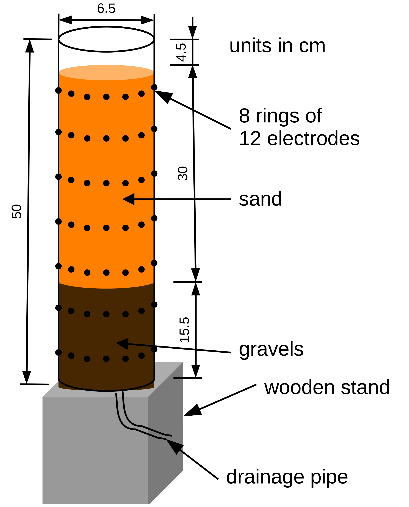

The column is saturated until ponding then it is drained for 24h (first graph). After that, water is infiltrated at the top at a rate of 40 mm/h and outflow is monitored (second graph). Note that both graphs show the **cumulative** outflow. Given that steady state is reached within the first hours, we will limit the simulation of drainage and infiltration phase to 4 hours each.

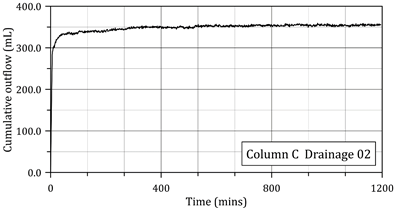
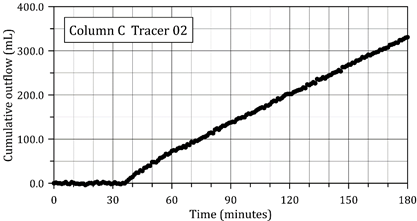

## Simulations
The reference folder which contains the original Hydrus 1D files, is `water-only-drainage-tracer` (only water, no solute). It starts with a saturated column that is left to drain for 4 hours (240 minutes), then the tracer (just water) is injected at a continuous rate (-0.6667 mm/min = -40 mm/h) for 4 hours. Several observations nodes have been placed for each electrode rings and at the bottom of the column (`Flux.8` corresponding to the outflow observation node).

In [2]:
# load useful python packages if "module not found", do "pip install <module_name>"
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shutil
import os
import time
import tempfile
import seaborn as sns
import subprocess
from subprocess import Popen, PIPE, run, DEVNULL
import platform
OS = platform.system()

Setting up working directory at the top of the script as *relative path* enables to easily move the directory tree to another machine without having to rename all files. Note that for the executables, the *absolute path* is required.

In [3]:
# working directories
datadir = '../modelling/' # the datadir is the folder called "modelling"
refdir = datadir + 'ref-water-only-drainage-tracer/' # path to reference Hydrus-1D folder
refERTdir = datadir + 'ref-ert-forward-seq3/' # path to reference forward ERT R3t folder
h1d = os.path.abspath(datadir + 'software/H1D_CALC.exe') # path to H1D_CALC.exe
r3t = os.path.abspath(datadir + 'software/R3t.exe') # path to R3t.exe
invdir = datadir + '../inversion/' # for ERT modelling
savedir = datadir + 'save/' # save dataframe from simulations results

Given the electrode ring positions and the discretization (1D mesh) used inside the Hydrus 1D modelling, we assign node index to each ring based on the node which is closer to the ring. These nodes are called 'observation node' within Hydrus and the variables modelled (soil moisture content, tension, ...) will be logged with time at these observation nodes.

Hydrus nodes (one node every 0.5 cm):  [ 0 12 24 34 46 56 68 80 90]


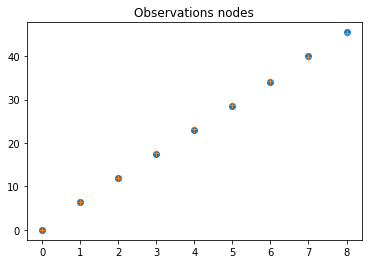

In [4]:
# computing observations nodes for Hydrus
elecRing = np.linspace(6.5, 7*5.55+6.5, 8)
obsNodesRaw = np.r_[0, elecRing]
obsNodes = np.round(obsNodesRaw/5, decimals=1)*5
fig, ax = plt.subplots()
ax.set_title('Observations nodes')
ax.plot(obsNodes, 'o', label='snapped to node')
ax.plot(obsNodesRaw, '+', label='raw')
print('Hydrus nodes (one node every 0.5 cm): ', obsNodes.astype(int)*2)

Below we define a set of useful functions that simple read and write Van Genuchten parameters in the Hydrus 1D simulation file or enable to run executable in parallel (for Windows and Unix environement).

In [5]:
# utils functions
def graphShape(x):
    nrow = int(np.round(np.sqrt(x)))
    ncol = nrow
    if nrow*ncol < x:
        ncol = ncol+1
    return nrow, ncol

def vg(theta_r, theta_s, alpha, n, psi):
    return theta_r + (theta_s - theta_r)/((1+(alpha*np.abs(psi))**n)**(1-1/n))

def vginv(theta_r, theta_s, alpha, n, theta):
    return (1/alpha*(((theta_s-theta_r)/(theta-theta_r))**(1/(1-1/n))-1))**(1/n)

def getObsNode(wd): # get observation nodes
    df = pd.read_csv(os.path.join(wd,'Obs_Node.out'), delim_whitespace=True,
                     skiprows=9)
    df.drop(df.tail(1).index, inplace=True) # drop last row
    df = df.apply(pd.to_numeric, errors='coerce')
    df = df.rename(columns={'h':'h.0', 'theta':'theta.0','Flux':'Flux.0','Conc':'Conc.0'})
    # avoid the use of skipfooter and so we can use faster C parser
    return df

def getOutput(wd): # retrieve time information
    df = pd.read_csv(os.path.join(wd, 'T_Level.out'), delim_whitespace=True, header=5)
    df = df.iloc[2:-1,:].reset_index(drop=True) # drop first line with units
    df = df.apply(pd.to_numeric, errors='ignore')
    return df

def writeSHP(fname, y): # write soil hydraulic parameters
    with open(fname, 'r') as f: # read
        x = f.readlines()
    for i in range(0, y.shape[0]): # MIGHT NEED TO ADJUST THE LINE NUMBER
        x[26+i] = '{:f} {:f} {:f} {:f} {:f} {:f}\n'.format(y[i,0], y[i,1], y[i,2],
         y[i,3], y[i,4], y[i,5])
    with open(fname, 'w') as f: # write
        for i in range(len(x)):
            f.write(x[i])
            
def hdmod(wd, shp=None, exePath='H1D_CALC.exe', debug=False):
    timer = {}
    t0 = time.time()
    if shp is not None:
        writeSHP(os.path.join(wd, 'SELECTOR.IN'), shp)
    timer['write'] = time.time() - t0
    t0 = time.time()
    if OS == 'Windows':
        si = subprocess.STARTUPINFO()
        si.dwFlags |= subprocess.STARTF_USESHOWWINDOW
    if OS == 'Windows':
        proc = run([exePath, wd], startupinfo=si,
                     stdin=None, stdout=PIPE, stderr=PIPE)
    if OS == 'Linux':
        proc = run(['wine', exePath, wd],
                     stdin=None, stdout=PIPE, stderr=PIPE)
    timer['run'] = time.time() - t0
    t0 = time.time()
    if debug is True:
        print(proc.stdout.decode('utf-8').split('\r\n')[-3:])    
    df = getObsNode(wd)
#     df = getOutput(wd)
    timer['read'] = time.time() - t0
    print('hdmod: write ({:.2f}s), run ({:.2f}s), read ({:.2f}s)'.format(
        timer['write'], timer['run'], timer['read']))
    return df

def runParallel(wds, exePath, icwd=False, njobs=8):
    """Run in parallel using a cross-platform approach."""
    procs = [] # processes handles
    if OS != 'Windows':
        si = None
    else:
        si = subprocess.STARTUPINFO()
        si.dwFlags |= subprocess.STARTF_USESHOWWINDOW
    cmd = ['wine', exePath] if OS != 'Windows' else [exePath]
    while True: # infinite loop :o
        while wds and len(procs) < njobs:
            wd = wds.pop()
            a = [] if icwd is True else [wd]
            b = wd if icwd is True else None
            proc = Popen(cmd + a, cwd=b, startupinfo=si,
                         stdin=DEVNULL, stdout=DEVNULL, stderr=DEVNULL)
            procs.append(proc)
        for proc in procs:
            if proc.poll() is not None: # process is done
                procs.remove(proc)
        if not procs and not wds:
            break # break out of infinite loop
        else:
            time.sleep(0.05) # always good to get some sleep

def phdmod(maindir, refdir, shps=[], exePath='H1D_CALC.exe', debug=False, njobs=8):
    """Run Hydrus in parallel in different folders
    
    Parameters
    ----------
    dirnames : list of str
        List of folder in which to run hydrus.
    """
    # write all directory
    t0 = time.time()
    print('write...', end='', flush=True)
    wds = []
    for i, shp in enumerate(shps):
        wd = os.path.join(maindir, str(i))
        if os.path.exists(wd):
            shutil.rmtree(wd)
        shutil.copytree(refdir, wd)
        writeSHP(os.path.join(wd, 'SELECTOR.IN'), shp)
        wds.append(wd)
    print(' ({:.2f}s), '.format(time.time() - t0), end='', flush=True)

    # run them all in parallel    
    t0 = time.time()
    print('run...', end='', flush=True)
    wds2 = wds.copy() # for data retrieval later
    runParallel(wds, exePath, njobs)
    print(' ({:.2f}s), '.format(time.time() - t0), end='', flush=True)
    
    # collect data
    t0 = time.time()
    print('read...', end='', flush=True)
    dfs = [getObsNode(wd) for wd in wds2]
    print(' ({:.2f}s)'.format(time.time() - t0))
    
    return dfs

## Synthetic model
In this section we can either produce a set of synthetic outflows by specifying the flow parameters, or we can simply load a .csv with the flow data. Note that the column `Flux.8` refers to the 8th observation node which is the one at the bottom of the column that we consider to be the outflow (we neglect the pipe connecting the bottom of the column to the cylinder).

This part of the code also define the default flow parameters values `shp0`.

hdmod: write (0.00s), run (0.07s), read (0.02s)


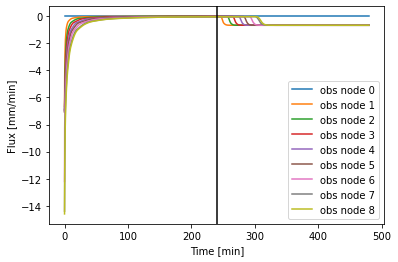

In [7]:
# synthetic true model (to define the default shp values)
wd = datadir + '1/'
if os.path.exists(wd):
    shutil.rmtree(wd)
shutil.copytree(refdir, wd)

# parameters
shpRef = np.array([[0.045, 0.31, 0.03, 2.68, 4.95, 0.5], # originally from H1D
                   [0.045, 0.47, 0.03, 2.68, 8, 0.5]])
pTrue = {'Ks (sand)': 7,
         'Ks (gravel)': 15,
         'n (sand)': 2.68}
shp = np.array([[0.045, 0.31, 0.03, pTrue['n (sand)'], pTrue['Ks (sand)'], 0.5],
                [0.045, 0.47, 0.03, 2.68, pTrue['Ks (gravel)'], 0.5]])
shp0 = pd.DataFrame(shp, columns=['theta_r', 'theta_s', 'alpha','n','Ks','l'])

# simuation
df0 = hdmod(wd, shp=shp, exePath=h1d)

# graph
fig, ax = plt.subplots()
for i in range(9):
    ax.plot(df0['time'].values, df0['Flux.' + str(i)], label='obs node ' + str(i))
ax.legend()
ax.set_ylabel('Flux [mm/min]')
ax.set_xlabel('Time [min]')
ax.axvline(4*60, color='k')

## Full MC simulations with ERT
The workflow below is decomposed as this:
1) **parameter definitions**: we define how many realization we want to do (`nreaz`) and the distribution of the parameters to be resolved (using the `dfp['<parameter_name>']`). We also select the print times we are interested in (i.e. the ones among `ptimesAll` where we want to model the resistivity response). Remember that indexing in Python starts at 0. This selection among print times is done for optimization of the computation (we selected 4 dates as we have 4 cores available on our machine). Note that to have other available print times, we need to change the file `SELECTOR.IN` inside the reference Hydrus-1D modeling folder. Hydrus-1D limits the number of print times to 10.
2) **`runSimulations()`**: this functions runs the simulations as this:
    - a) first the Hydrus 1D simulations are run in parallel (`phdmod()`)
    - b) at the selected print times, the soil moisture content profile is retrieved and converted to resistivity using a petrophysical relationship (we don't care so much about it as we are interested at difference(percent))
    - c) for each realization, we simulate the forward ERT response in parallel for selected print times (`ptimes`). Given the reference forward ERT folder (created using ResIPy), we copy this folder for each `ptime` and write back the `resistivity.dat` file with the corresponding resistivity computed from the flow. For each realization, all `ptime` are then run in parallel with `runParallel()` function.
    - d) while the results of the outflows are stored in a list of dataframes (`dfs`), the results of the ERT simulations are stored in a list of dataframes (`dfres`), each dataframe corresponding a realization with all its `ptimes` (print times).

In [12]:
# simulations to find back the true model (11.6s per 100 simulations)
# default value from H1D simulations
shp = np.array([[0.045, 0.31, 0.03, 2.68, 4.95, 0.5], # original from H1D
                [0.045, 0.47, 0.03, 2.68, 8, 0.5]])
shp0 = pd.DataFrame(shp, columns=['theta_r', 'theta_s', 'alpha','n','Ks','l'])

# setup parameter prior distributions
nreaz = 10 # 10^number of parameters to be adjusted
dfp = pd.DataFrame() # parameter dataframe
dfp['Ks (sand)'] = np.random.uniform(low=1, high=20, size=nreaz) # [mm/min]
dfp['Ks (gravel)'] = np.random.uniform(low=1, high=20, size=nreaz)
# dfp['n (sand)'] = np.random.uniform(low=1, high=3, size=nreaz)
pNames = dfp.columns.values
ps = dfp.values.T # (nparam, nreaz)

ptimesAll = np.array([1, 60, 120, 239, 250, 260, 270, 480]) # [min] as setup in SELECTOR.IN
iptimes = np.array([0,1,3,4]) # 2 in drainage and 2 in tracer01
# iptimes = np.array([0,1,2,3]) # all during drainage
# iptimes = np.array([3,4,5,6]) # all during tracer01
ptimes = ptimesAll[iptimes]

def runSimulations(dfp, ptimes, iert=True):
    # clean up directories
    if os.path.exists(datadir + 'parallel'):
        shutil.rmtree(datadir + 'parallel')
    os.mkdir(datadir + 'parallel')
    if os.path.exists(datadir + 'parallelERT'):
        shutil.rmtree(datadir + 'parallelERT')
    os.mkdir(datadir + 'parallelERT')

    # setting up Hydrus parameters
    shps = []
    df = shp0.copy()
    for i in range(ps.shape[1]): # for each realization
        df.loc[0, 'Ks'] = dfp['Ks (sand)'][i]
        df.loc[1, 'Ks'] = dfp['Ks (gravel)'][i]
    #     df.loc[0, 'n'] = dfp['n (sand)'][i]
        shps.append(df.values.copy()) # need copy otherwise it's just references
    
    # Hydrus simulations
    print('===== Hydrus 1D simulations =====')
    dfs = phdmod(datadir + 'parallel/', refdir, shps=shps, exePath=h1d, njobs=8)

    # convert to ERT
    if iert is False:
        return dfs, []
    print('====== R3t forward simualtions ======')
    dfert = []
    runTimes = []
    labs = ['h.{:d}'.format(a) for a in range(9)] # head at obs nodes
    for i, df in enumerate(dfs):
        hs = np.zeros((len(labs), len(ptimes)))
        for j in range(len(ptimes)):
            imin = np.argmin(np.abs(df['time']-ptimes[j]))
            hs[:,j] = df[labs].values[imin,:]
        hs = np.flipud(hs) # not sure why

        # convert to theta (only for sand for now)
        thetas = vg(*shp0[['theta_r','theta_s','alpha','n']].values[0,:], hs)

        # convert to resisitivity (assumed -> doesn't matter if differences AND linear)
        res = 10000/(50*thetas**1)

        # prepare folders and set resistivity.dat according to simulated flow
        t0 = time.time()
        dirnames = [datadir + 'parallelERT/{:d}/'.format(i) for i in range(len(ptimes))]
        for j, dirname in enumerate(dirnames):
            if i == 0: # first time, let's create the directories
                if os.path.exists(dirname):
                    shutil.rmtree(dirname)
                shutil.copytree(refERTdir, dirname)
            # update resistivity
            resdat = pd.read_csv(dirname + 'invdir/fwd/resistivity.dat', sep='\t', header=None)
            resdat = resdat.rename(columns={1:'xc',2:'yc',3:'zc',4:'res0',5:'log10'})
            resdat['res0'] = np.interp(resdat['zc'].values, obsNodes, res[:,j])
            resdat['log10'] = np.log10(resdat['res0'])
            resdat.to_csv(dirname + 'invdir/fwd/resistivity.dat', sep='\t', index=False, header=None)

        # run them all in parallel
        wds = [d + 'invdir/fwd/' for d in dirnames]
        wds2 = wds.copy()
        runParallel(wds, exePath=r3t, icwd=True, njobs=4)

        # extract raw resistivity values
        dfres = pd.DataFrame()
        for j, wd in enumerate(wds2):
            df = pd.read_csv(os.path.join(wd, 'R3t_forward.dat'), skiprows=1,
                               delim_whitespace=True, header=None)
            df = df.rename(columns=dict(zip(np.arange(11),
                ['index','sa','a','sb','b','sm','m','sn','n','resist','app'])))
            dfres['ptime{:.0f}'.format(ptimes[j])] = df['resist'].values
            if j == 0:
                res0 = df['resist'].values
            else: # compute difference(percent) compared to first measurements!!
                dfres['diff{:.0f}'.format(ptimes[j])] = (df['resist'].values - res0)/res0*100
        dfert.append(dfres)
        runTimes.append(time.time() - t0)
        print('\r{:d}/{:d} done ({:.2f} s per realization)'.format(
            (i+1)*len(ptimes), dfp.shape[0]*len(ptimes), np.mean(runTimes)), end='', flush=True)
    print('')

    return dfs, dfert

dfs, dfert = runSimulations(dfp, ptimes)

===== Hydrus 1D simulations =====
write... (0.08s), run... (0.31s), read... (0.22s)
====== R3t forward simualtions ======
40/40 done (5.07 s per realization)


In [11]:
# save dataframes outputed by simulations (optional)
if os.path.exists(savedir):
    shutil.rmtree(savedir)
os.mkdir(savedir)
dfp.to_csv(savedir + 'dfp.csv', index=False)
for i, df in enumerate(dfs):
    df.to_csv(savedir + 'df{:d}.csv'.format(i), index=False)
for i, df in enumerate(dfert):
    df.to_csv(savedir + 'dfres{:d}.csv'.format(i), index=False)

In [12]:
# load dataframes from previous simulations (optional)
dfp = pd.read_csv(savedir + 'dfp.csv')
dfs = []
for i in range(100000):
    fname = savedir + 'df{:d}.csv'.format(i)
    if os.path.exists(fname):
        dfs.append(pd.read_csv(fname))
    else:
        break
dfert = []
for i in range(100000):
    fname = savedir + 'dfres{:d}.csv'.format(i)
    if os.path.exists(fname):
        dfert.append(pd.read_csv(fname))
    else:
        break

## Observed data and misfit computation
The observed outflow data can be loaded from .csv. This .csv is formed by merging the first 4 hours of the drainage time and then the first 4 hours of the tracer infiltration time. The columns containing the outlfow in mm/min is called `Flux.8` to correspond to the output of the Hydrus modelling. The time column (in min) is called `time`.

Note that here, we apply a rolling mean to smooth the data. As this creates NaN at the end of the serie, we then need to drop them. Doing so overwrite the `df0` dataframe which is the dataframe of outflow observations containing a `time` and a `Flux.8` columns.

The ERT datasets corresponding to the selected print times (`ptimes`) are loaded selectively from the pool of "drainage datasets" and "infiltration dataset". They are then merge together in a single dataframe with the same header as the ones produces by the modeling (i.e. with `ptime160` for the resistances results at 160 min after simulation start and `diff160` for the percentage difference between the first print time and `ptime160`).

**To compute misfit against another column, change the path of the observed outflow and ERT (drainage and infiltration) protocol files.**

77.84 s per survey


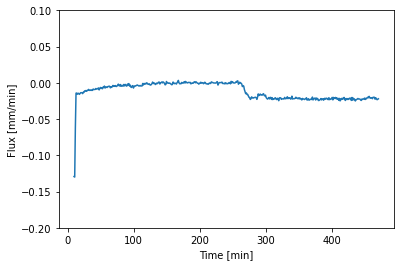

In [13]:
# load outflow and ERT observations
df0 = pd.read_csv(datadir + 'outflow-column-d.csv') # CHANGE HERE
df0 = df0.rolling(window=20).mean() # smoothing a bit
df0 = df0.dropna().reset_index(drop=True) # NaN introduced by smoothing
fig, ax = plt.subplots()
ax.plot(df0['time'], df0['Flux.8'])
ax.set_ylabel('Flux [mm/min]')
ax.set_xlabel('Time [min]')
ax.set_ylim([-0.2, 0.1])

# load ERT datasets
surveyTime = 4*60*60/185 # [s]
print('{:.2f} s per survey'.format(surveyTime))
# load survey corresponding to print times (ptimes)
for i, ptime in enumerate(ptimes):
    if ptime < 240:
        fname = datadir + '../newdata/Column D/protocolColumnD_drainage.dat' # CHANGE HERE
    else:
        fname = datadir + '../newdata/Column D/protocolColumnD_tracer01.dat' # CHANGE HERE
    if i == 0:
        dfertObs = pd.read_csv(fname, skiprows=1+i*173, nrows=172,
                               delim_whitespace=True, header=None)
        res0 = dfertObs.loc[:,9].values
        dfertObs = dfertObs.rename(columns=dict(zip(np.arange(10),
            ['index','sa','a','sb','b','sm','m','sn','n','ptime{:d}'.format(ptime)])))
    else:
        res = pd.read_csv(fname, skiprows=1+i*173, nrows=172, 
                          delim_whitespace=True, header=None)[9].values
        dfertObs['ptime{:d}'.format(ptime)] = res
        dfertObs['diff{:d}'.format(ptime)] = (res-res0)/res0*100 # difference(percent)

The misfit (RMSE) is computed in three different ways:
- `rmseOutflow`: just based on the observed and simulated outflow
- `rmseERT-abs`: based on the absolute ERT measurements observed - NOTE: this one isn't good at all as heavily influenced by the assumed petrophysical relationship
- `rmseERT-diff`: based on the difference(percent) in resistances with reference to the first print times. Much more robust.

For each realization, all parameters sets selected and RMSE computed are stored in `dfout`.

In [14]:
# compute misfit
def misfit(obs, sim): # for outflow
    qobs = obs['Flux.8'].values
    qobsTime = obs['time'].values
    qsim = sim['Flux.8'].values
    qsimTime = sim['time'].values
    qsim2 = np.interp(qobsTime, qsimTime, qsim)
    return np.sqrt(np.sum((qobs - qsim2)**2)/len(qobs))

# for ERT
acols = ['ptime{:d}'.format(ptime) for ptime in ptimes]
dcols = ['diff{:d}'.format(ptime) for ptime in ptimes[1:]]
def rmse(dfsim, dfobs, cols):
    sim = dfsim[cols].values.flatten()
    obs = dfobs[cols].values.flatten()
    return np.sqrt(np.sum((sim-obs)**2)/len(obs))

dfout = dfp.copy()
dfout['rmseOutflow'] = np.array([misfit(df0, df) for df in dfs])
dfout['rmseERT-abs'] = np.array([rmse(df, dfertObs, acols) for df in dfert])
dfout['rmseERT-diff'] = np.array([rmse(df, dfertObs, dcols) for df in dfert])
dfout.to_csv(savedir + 'out.csv', index=False)
dfout

Ks (sand)  Ks (gravel)  rmseOutflow   rmseERT-abs  rmseERT-diff
0    11.347514     7.922998     0.487894  12392.874412    908.649849
1    17.117242     5.912936     0.486735  12387.817869    908.022889
2    12.082398     1.145376     0.503782  12391.259311    921.451332
3     4.182286     8.128536     0.480308  12401.982612    906.865271
4     3.603830     5.953408     0.477520  12402.794346    906.427350
..         ...          ...          ...           ...           ...
995  15.259338    15.827054     0.479005  12389.314991    909.271674
996   8.677939     3.568969     0.488898  12395.707371    907.336838
997  16.284057     2.929816     0.502391  12388.082944    910.971258
998   2.776295     3.422416     0.465402  12404.120002    905.919330
999  18.212857    16.816228     0.475859  12387.013035    909.433580

[1000 rows x 5 columns]

## Posterior distributions
Given the parameters sets and the computed misfit, we plot the posterior distribution by selecting the 10% best misfit (we can also set a manual threshold).

Number of samples with rmseOutflow < 0.463 : 100
best parameters:
Ks (sand)       :  2.60
Ks (gravel)     : 10.15
Number of samples with rmseERT-abs < 12387.271 : 100
best parameters:
Ks (sand)       : 18.89
Ks (gravel)     : 11.59
Number of samples with rmseERT-diff < 906.300 : 100
best parameters:
Ks (sand)       :  2.38
Ks (gravel)     : 10.54


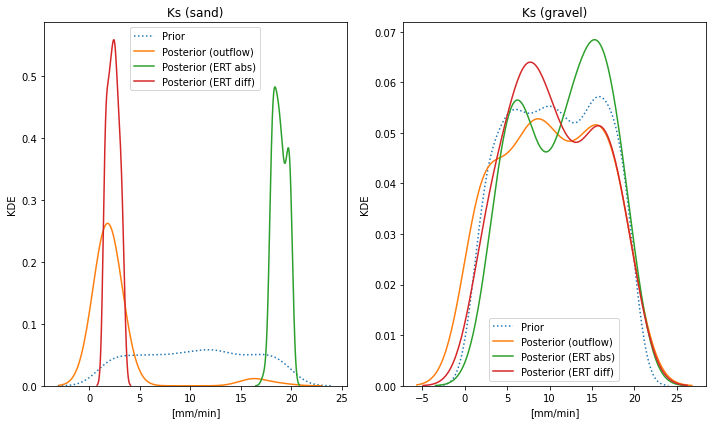

In [15]:
# posterior distributions

# threshold (either fixed or percentile value)
ies = []
for col in ['rmseOutflow', 'rmseERT-abs', 'rmseERT-diff']:
    rmses = dfout[col].values
    threshold = np.nanpercentile(rmses, 10) # CHANGE HERE
    # threshold = 0.05 # CHANGE HERE manually set
    ie = rmses < threshold # take best samples below threshold
    print('Number of samples with {:s} < {:.3f} : {:d}'.format(col, threshold, np.sum(ie)))
    pBest = dict(zip(pNames, np.mean(ps[:,ie], axis=1))) # mean of best parameters set
    print('best parameters:')
    for pb in pBest:
        print('{:<16s}: {:5.2f}'.format(pb, pBest[pb]))
    ies.append(ie)

# graph of distributions
units = ['[mm/min]', '[mm/min]']
a, b = graphShape(len(pNames))
fig, axs = plt.subplots(a, b, figsize=(10, 6))
axs = axs.flatten()
for i, pName in enumerate(pNames):
    ax = axs[i]
    ax.set_title(pName)
    sns.kdeplot(ps[i,:], ax=ax, linestyle=':', label='Prior')
    sns.kdeplot(ps[i,ies[0]], ax=ax, label='Posterior (outflow)')
    sns.kdeplot(ps[i,ies[1]], ax=ax, label='Posterior (ERT abs)')
    sns.kdeplot(ps[i,ies[2]], ax=ax, label='Posterior (ERT diff)')
    ax.set_xlabel(units[i])
    ax.set_ylabel('KDE')
    ax.legend()
fig.tight_layout()